In [2]:
import os
from torch.utils.data import DataLoader # type: ignore
from torchvision.datasets import ImageFolder # type: ignore
import torchvision.transforms as tt # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
# import torchmetrics as tm # type: ignore
import cv2 # type: ignore
from tqdm.notebook import tqdm # type: ignore
import torch.nn.functional as F # type: ignore
from torchvision.utils import save_image # type: ignore
from torchvision.utils import make_grid # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [3]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
for param in backbone_model.parameters():
    param.requires_grad = False
# backbone_model.cuda()




Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/loki/.cache/torch/hub/main.zip
/home/loki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/loki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/loki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /home/loki/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
 31%|███       | 26.0M/84.2M [00:23<00:52, 1.16MB/s]


KeyboardInterrupt: 

In [3]:
# class CD_Dataset:
#     def __init__(self, path, transforms = None):
#         self.path = path
#         self.transforms = transforms
        

In [36]:
DATA_DIR = '/home/alok/dinov2/Cat_Dog_dataset'

TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set', 'training_set')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set', 'test_set')
image_size = 224
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
def is_valid_file(path):
    if(path.endswith(".jpg") or path.endswith(".jpeg") or path.endswith(".png")):
        return True
    return False

In [6]:
train_ds = ImageFolder(TRAIN_DATA_DIR, transform=tt.Compose([
    tt.RandomRotation(degrees=10, expand=True, interpolation=tt.InterpolationMode.BICUBIC),
    tt.RandomResizedCrop(size=(224, 224), antialias=True),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats)
]), is_valid_file = is_valid_file)

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))    

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

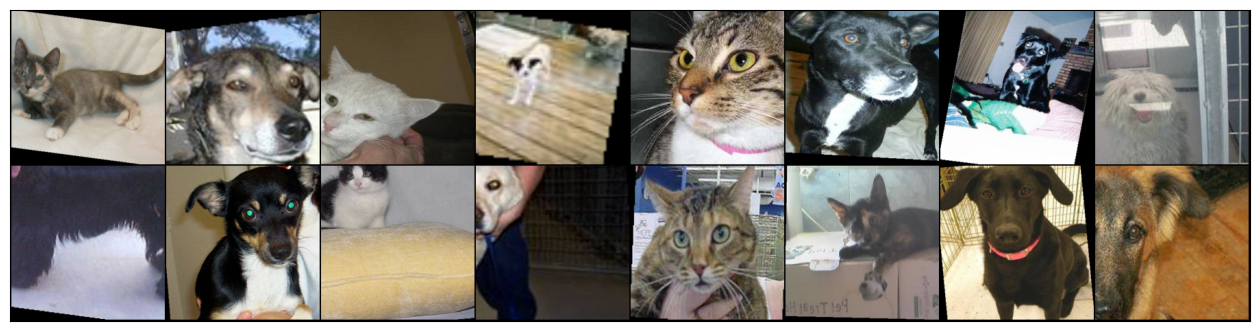

In [10]:
show_batch(train_dl)

In [25]:
X,Y = [], []
flags = [0] * 16
for x,y in train_dl:
    X.append(x)
    Y.append(y)

In [27]:
print(len(X))
print(X[0].shape)

501
torch.Size([16, 3, 224, 224])


In [13]:
# idx = np.random.randint(0, len(X))
# show_images(X[idx][0:1])
# print(Y[idx][0])

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
train_dl = DeviceDataLoader(train_dl, device)


In [17]:
model = nn.Sequential(backbone_model,
                      nn.Linear(384,192, bias=False),
                      nn.BatchNorm1d(192),
                      nn.ReLU(inplace=True),
                      nn.Linear(192,48, bias=False),
                      nn.BatchNorm1d(48),
                      nn.ReLU(inplace=True),
                      nn.Linear(48,1),
                      nn.Sigmoid()
                      )
model = to_device(model, device)

In [64]:
def fit(model, criterion, metric, epochs, lr, start_idx=1):
    model.train()
    torch.cuda.empty_cache()
    # metric = to_device(metric, device)
    
    # Losses & scores
    losses = []
    scores = []
    # Create optimizers
    optimizer = torch.optim.AdamW(model.parameters(), 
                                    lr=lr, 
                                    betas=(0.9, 0.999), 
                                    weight_decay=0.01)
    
    for epoch in tqdm(range(epochs)):
        loss_per_epoch = []
        score_per_epoch = []
        for images, labels in tqdm(train_dl):
            # Train 
            optimizer.zero_grad()

            preds = to_device(model(images), device)
            labels = to_device(torch.unsqueeze(labels, 1).type(torch.FloatTensor), device)
            loss = criterion(preds, labels)
            # labels = labels.type(torch.LongTensor).to(device)
            cur_score = torch.sum((preds>0.5) == labels).item()/preds.shape[0]
            
            loss.backward()
            optimizer.step()
            loss_per_epoch.append(loss.item())

            score_per_epoch.append(cur_score)
            
        # Record losses & scores
        # metric.reset()
        losses.append(np.mean(loss_per_epoch))
        scores.append(np.mean(score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss: {:.4f}, score: {:.4f}".format(
            epoch+1, epochs, 
            losses[-1], scores[-1]))
    
    
    return losses, scores

In [65]:
criterion = nn.BCELoss()
accuracy = tm.Accuracy()
lr = 0.0001
epochs = 10

In [66]:
history = fit(model, criterion, accuracy, epochs, lr)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.0317, score: 0.9878


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.0333, score: 0.9879


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.0377, score: 0.9882


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.0349, score: 0.9864


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.0293, score: 0.9886


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.0263, score: 0.9900


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.0308, score: 0.9878


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.0334, score: 0.9863


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.0348, score: 0.9878


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.0276, score: 0.9889


tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
[tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')]


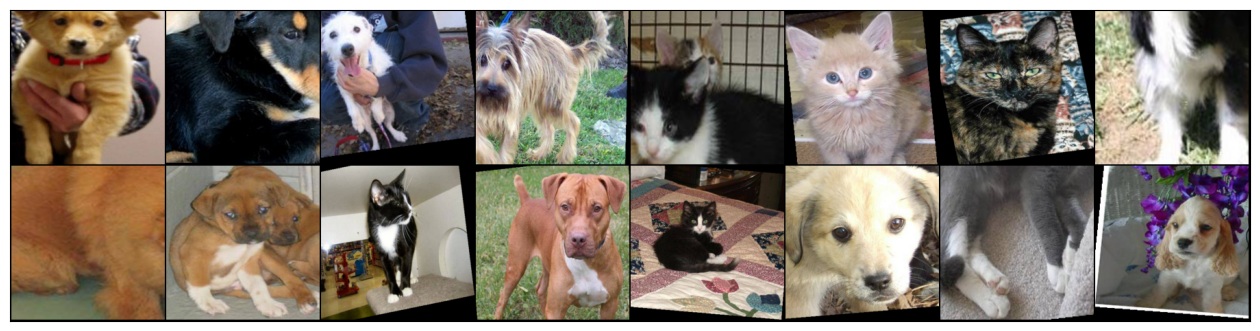

In [67]:
model.eval()
print(torch.squeeze((model(X[0])>0.5)*1))
show_images(X[0].detach().cpu())
print(Y[0:1])


In [68]:
train_losses, train_scores = history

In [69]:
test_ds = ImageFolder(TEST_DATA_DIR, transform=tt.Compose([
    tt.Resize(224),
    tt.CenterCrop(224),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))
test_dl = DataLoader(test_ds, 1, shuffle=False, num_workers=2, pin_memory=True)

test_dl = DeviceDataLoader(test_dl, device)


In [70]:
def validate(model, criterion, metric, epochs = 1, start_idx=1):
    model.eval()
    torch.cuda.empty_cache()
    # metric = to_device(metric, device)
    
    # Losses & scores
    losses = []
    scores = []
    for epoch in tqdm(range(epochs)):
        loss_per_epoch = []
        score_per_epoch = []
        for images, labels in tqdm(test_dl):
            # Train 

            preds = to_device(model(images), device)
            labels = to_device(torch.unsqueeze(labels, 1).type(torch.FloatTensor), device)
            loss = criterion(preds, labels)
            # labels = labels.type(torch.LongTensor).to(device)
            cur_score = torch.sum((preds>0.5) == labels).item()/preds.shape[0]
            
            loss_per_epoch.append(loss.item())

            score_per_epoch.append(cur_score)
            
        losses.append(np.mean(loss_per_epoch))
        scores.append(np.mean(score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss: {:.4f}, score: {:.4f}".format(
            epoch+1, epochs, 
            losses[-1], scores[-1]))
    
    return losses, scores

In [71]:
test_history = validate(model, criterion, accuracy)
test_losses, test_scores = test_history

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2023 [00:00<?, ?it/s]

Epoch [1/1], loss: 0.0120, score: 0.9970


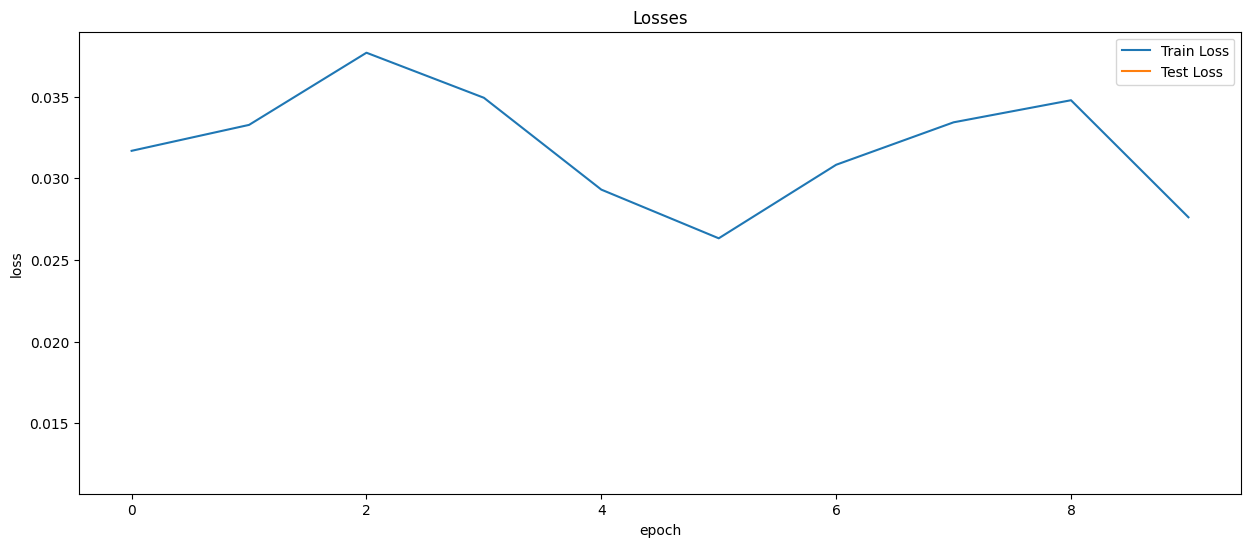

In [72]:
plt.figure(figsize=(15, 6))
plt.plot(train_losses, '-')
plt.plot(test_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train Loss', 'Test Loss'])
plt.title('Losses');

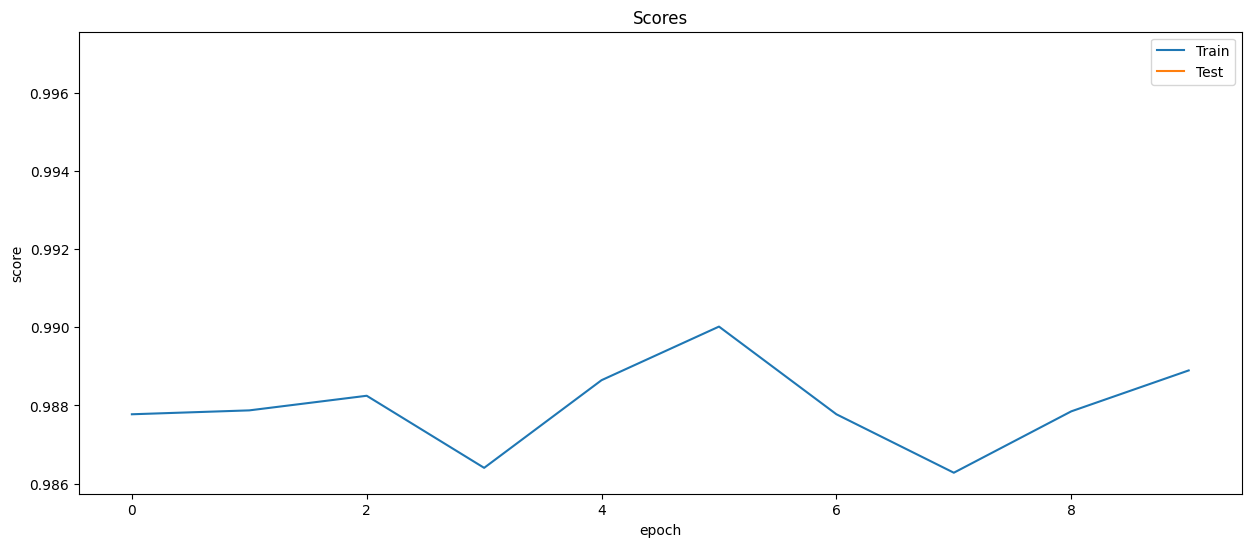

In [73]:
plt.figure(figsize=(15, 6))

plt.plot(train_scores, '-')
plt.plot(test_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Train', "Test"])
plt.title('Scores');